In [19]:
import os
import random
import numpy as np
import cv2
import time

from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

# General

In [41]:
IN_LABEL = 'inputs/labels'
IN_IMG = 'inputs/images'

OUT_IMG = 'outputs/images'
OUT_LABEL = 'outputs/labels'

threshold = 0.01

## Remove Very Small Objects

In [26]:
threshold = 0.0005
for item in os.listdir(OUT_IMG):
    txt = item.replace(item[-4:], '.txt')
    ann = np.loadtxt(os.path.join(OUT_LABEL, txt)).tolist()
    
    # multiple objects
    if type(ann[0]) == list:
        for obj in ann:
            if obj[3]*obj[4] < threshold:
                ann.remove(obj)
        if ann != []:
            np.savetxt(os.path.join(OUT_LABEL, txt), ann, fmt='%.10g')
        else:
            os.remove(os.path.join(OUT_IMG, item))
            os.remove(os.path.join(OUT_LABEL, txt))

    # single object    
    else:
        if ann[3]*ann[4] < threshold:
            os.remove(os.path.join(OUT_LABEL, txt))
            os.remove(os.path.join(OUT_IMG, item))

## Random Crop

In [8]:
# iaa.CropToFixedSize(position=(0,0)) is the buttom right corner of the plane and (1,1) is the upper left corner of the plane

In [42]:
# constants
width = 500
height = 500

In [49]:
a = time.time()
# Loop through the images
for item in os.listdir(IN_IMG):
    i = 0
    # Load
    txt = item.replace(item[-4:],'.txt')
    ann = np.loadtxt(os.path.join(IN_LABEL, txt)).tolist()
    image = cv2.imread(os.path.join(IN_IMG, item))


    # Multiple objects
    if type(ann[0]) == list:

        ann_copy = ann.copy()

        # Specify bboxes
        h, w ,c = image.shape
        bbs = BoundingBoxesOnImage(
            [BoundingBox(x1=(obj[1]-obj[3]/2)*w, x2=(obj[1]+obj[3]/2)*w, y1=(obj[2]-obj[4]/2)*h, y2=(obj[2]+obj[4]/2)*h) for obj in ann]
            , shape=image.shape)
        
        
        
        # Loop through objects
        for element in ann:
            annotation = []
            
            # Names
            i += 1
            new_img_name = f'{item[:-4]}_{i}{item[-4:]}'
            new_label_name = f'{txt[:-4]}_{i}{txt[-4:]}'


            # Is it small?
            if element[3]*element[4] < threshold:
                
                # Randomness
                r = random.uniform(-1,1)
                # Center
                x = 1-(element[1]-((width/(2*w))*r))
                y = 1-(element[2]-((height/(2*h))*r))
                
                if x > 1:
                    x = 1
                if x < 0:
                    x = 0
                if y > 1:
                    y = 1
                if y < 0:
                    y = 0
                    
                # Crop
                seq = iaa.Sequential([
                iaa.CropToFixedSize(width=width, height=height, position=(x,y))
                ])
                # Output
                image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

                
                for e in bbs_aug:
                    xmin=e[0][0]
                    ymin=e[0][1]
                    xmax=e[1][0]
                    ymax=e[1][1]
                    
                    x_center = (xmax+xmin)/(2*width)
                    y_center = (ymax+ymin)/(2*height)
                    obj_width = (xmax-xmin)/width
                    obj_height = (ymax-ymin)/height
                    
                    # Make sure objects are 50% inside
                    if 0 < x_center < 1 and 0 < y_center < 1:
                        if xmin < 0:
                            obj_width = obj_width - abs(xmin/width)
                            xmin = 0
                            x_center = (xmax+xmin)/(2*width)
                        if xmax > width:
                            obj_width = obj_width - abs((xmax-width)/width)
                            xmax = width
                            x_center = (xmax+xmin)/(2*width)
                        if ymin < 0:
                            obj_height = obj_height - abs(ymin/width)
                            ymin = 0
                            y_center = (ymax+ymin)/(2*height)
                        if ymax > height:
                            obj_height = obj_height - abs((ymax-height)/height)
                            ymax = height
                            y_center = (ymax+ymin)/(2*height)
                            
                            
                        annot = [int(0), x_center, y_center, obj_width, obj_height]
                        annotation.append(annot)

                
                # Save cropped images
                if annotation != []:
                    np.savetxt(os.path.join(OUT_LABEL, new_label_name), annotation, fmt='%.10g')
                    cv2.imwrite(os.path.join(OUT_IMG, new_img_name), image_aug)
                    
                ann_copy.remove(element)
                    
        # Save the big image (but small objects removed)
        if ann_copy != []:
            np.savetxt(os.path.join(OUT_LABEL, txt), ann_copy, fmt='%.10g')
            cv2.imwrite(os.path.join(OUT_IMG, item), image)


            
            
            
            
            
            

    # Single object    
    else:

        # Is it small?
        if ann[3]*ann[4] < threshold:
            obj = ann

            # extract h, w
            h, w , c = image.shape
            bbs = BoundingBoxesOnImage([
                BoundingBox(x1=(obj[1]-obj[3]/2)*w, x2=(obj[1]+obj[3]/2)*w, y1=(obj[2]-obj[4]/2)*h, y2=(obj[2]+obj[4]/2)*h)]
                , shape=image.shape)


            # Randomness
            r = random.uniform(-1,1)
            x = 1-(obj[1]-((width/(2*w))*r))
            y = 1-(obj[2]-((height/(2*h))*r))
            
            if x > 1:
                x = 1
            if x < 0:
                x = 0
            if y > 1:
                y = 1
            if y < 0:
                y = 0
                
            # Crop
            seq = iaa.Sequential([
            iaa.CropToFixedSize(width=width, height=height, position=(x,y))
            ])

            # Output
            image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

            
            e = bbs_aug
            xmin=e[0][0][0]
            ymin=e[0][0][1]
            xmax=e[0][1][0]
            ymax=e[0][1][1]
            

            x_center = (xmax+xmin)/(2*width)
            y_center = (ymax+ymin)/(2*height)
            obj_width = (xmax-xmin)/width
            obj_height = (ymax-ymin)/height
            
            # Make sure objects are 50% inside
            if 0 < x_center < 1 and 0 < y_center < 1:
                if xmin < 0:
                    obj_width = obj_width - abs(xmin/width)
                    xmin = 0
                    x_center = (xmax+xmin)/(2*width)
                if xmax > width:
                    obj_width = obj_width - abs((xmax-width)/width)
                    xmax = width
                    x_center = (xmax+xmin)/(2*width)
                if ymin < 0:
                    obj_height = obj_height - abs(ymin/width)
                    ymin = 0
                    y_center = (ymax+ymin)/(2*height)
                if ymax > height:
                    obj_height = obj_height - abs((ymax-height)/height)
                    ymax = height
                    y_center = (ymax+ymin)/(2*height)
                    
                annot = [int(0), x_center, y_center, obj_width, obj_height]

            # Save
            np.savetxt(os.path.join(OUT_LABEL, 'single-cropped-'+txt), annot, newline=' ', fmt='%.10g')
            cv2.imwrite(os.path.join(OUT_IMG, 'single-cropped-'+item), image_aug)

        else:
            # If it's not small, keep it
            np.savetxt(os.path.join(OUT_LABEL, 'single-'+txt), ann, newline=' ', fmt='%.10g')
            cv2.imwrite(os.path.join(OUT_IMG, 'single-'+item), image)

        
b = time.time()
print(f'Done in {int((b-a)/60)} mins and {(b-a)-60*int((b-a)/60)} secs')

-3.9994812
Done in 1 mins and 29.06443476676941 secs


# Playground

In [29]:
1 < 1.5 < 2 and 1 < 0 < 2

False

In [ ]:
import matplotlib.pyplot as plt

In [140]:
image = io.imread('662.jpg')
ann = np.loadtxt('662.txt').tolist()

In [141]:
element = ann[0]

In [142]:
x = element[1]
y = element[2]

In [143]:
bbs = BoundingBoxesOnImage([
    BoundingBox(x1=(obj[1]-obj[3]/2)*w, x2=(obj[1]+obj[3]/2)*w, y1=(obj[2]-obj[4]/2)*h, y2=(obj[2]+obj[4]/2)*h) for obj in ann]
    , shape=image.shape)

In [144]:
h,w = image.shape[:2]

In [199]:
import random

In [286]:
r = random.uniform(-1,1)
while r == 0.0:
    r = random.uniform(-1,1)

(1-(xcenter-randomness) , 1-(ycenter-randomness)) s.t randomness = (width/2)*random s.t random in [-1,1] and random != 0

In [287]:
seq = iaa.Sequential([
iaa.CropToFixedSize(width=width, height=height, position=((1-(x-((width/(2*w))*r))),(1-(y-((height/(2*h))*r)))))
])
# Output
image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)

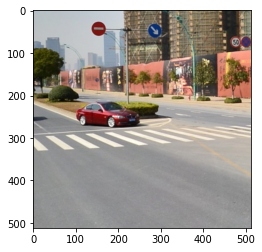

In [288]:
plt.imshow(image_aug)

In [34]:
a = [1,1,1,2,3,4,5,5,6]

In [35]:
b = a.copy()

In [37]:
b.remove(6)

In [38]:
b

[1, 1, 1, 2, 3, 4, 5, 5]

In [39]:
a

[1, 1, 1, 2, 3, 4, 5, 5, 6]